part 1

Loading Data...
Total Images: 11668


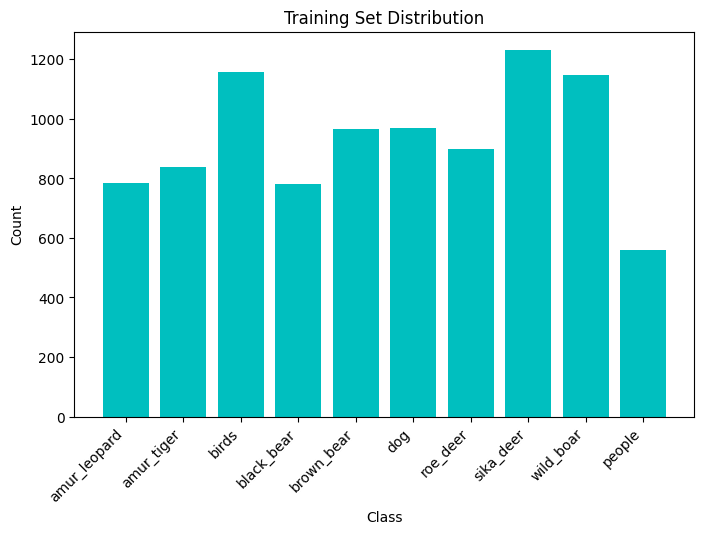

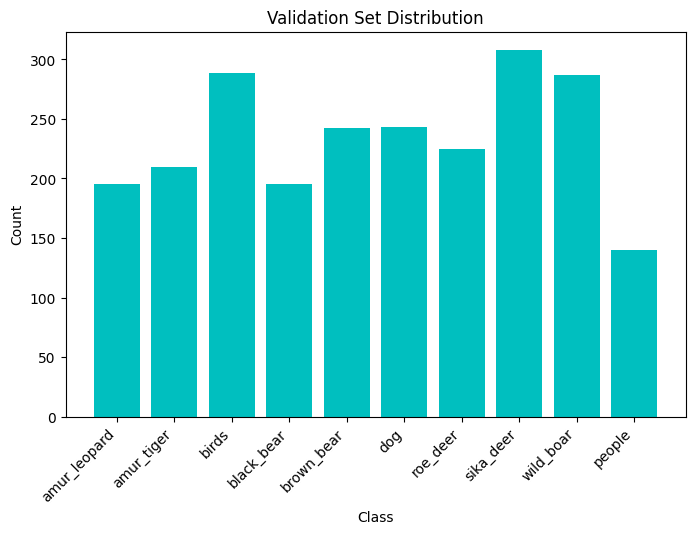

In [ ]:
import os
import torch
import wandb
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image

# ===================== Helper Functions =====================

def init_wandb(project_name="russian-wildlife"):
    """Initialize Weights & Biases."""
    wandb.init(project=project_name, reinit=True)

def set_random_seed(seed=2022053):
    """Set the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def load_image_paths_and_labels(data_dir, class_mapping):
    """Load image file paths and corresponding labels based on class_mapping."""
    image_paths = []
    labels = []
    print("Loading Data...")
    for class_name, class_label in class_mapping.items():
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                if img_file.endswith((".jpg", ".png", ".jpeg")):
                    image_paths.append(os.path.join(class_folder, img_file))
                    labels.append(class_label)
    # Convert lists to numpy arrays for later use
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    print(f"Total Images: {len(image_paths)}")
    return image_paths, labels

def stratified_split(image_paths, labels, test_size=0.2, seed=2022053):
    """Perform a stratified split on image paths and labels."""
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_idx, val_idx = next(splitter.split(image_paths, labels))
    train_paths = image_paths[train_idx]
    train_labels = labels[train_idx]
    val_paths = image_paths[val_idx]
    val_labels = labels[val_idx]
    return train_paths, train_labels, val_paths, val_labels

def get_transforms():
    """Return training and validation transforms."""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return train_transform, val_transform

def create_dataloaders(train_dataset, val_dataset, batch_size=32):
    """Create DataLoader objects for training and validation datasets."""
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def plot_class_distribution(labels, title, class_mapping):
    """Plot the distribution of classes given a label array."""
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar([list(class_mapping.keys())[i] for i in unique], counts, color='c')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# ===================== Dataset & Model Classes =====================

class WildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# ===================== Main Code Execution =====================

init_wandb()
set_random_seed()

# Define data directory and class mapping
data_dir = "russian-wildlife-dataset-20250204T231459Z-001/russian-wildlife-dataset/Cropped_final"
class_mapping = {
    'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3,
    'brown_bear': 4, 'dog': 5, 'roe_deer': 6, 'sika_deer': 7,
    'wild_boar': 8, 'people': 9
}

# Load image paths and labels
image_paths, labels = load_image_paths_and_labels(data_dir, class_mapping)

# Perform a stratified split
train_paths, train_labels, val_paths, val_labels = stratified_split(image_paths, labels)

# Get transformations
train_transform, val_transform = get_transforms()

# Create Dataset instances
train_dataset = WildlifeDataset(train_paths, train_labels, transform=train_transform)
val_dataset = WildlifeDataset(val_paths, val_labels, transform=val_transform)

# Create DataLoader objects
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)

# Visualize class distributions
plot_class_distribution(train_labels, "Training Set Distribution", class_mapping)
plot_class_distribution(val_labels, "Validation Set Distribution", class_mapping)

# Finish wandb logging for data prep phase
wandb.finish()




part b

Epoch [1/10], Loss: 2.0196, Accuracy: 0.2664
Epoch [2/10], Loss: 1.7182, Accuracy: 0.3957
Epoch [3/10], Loss: 1.5607, Accuracy: 0.4665
Epoch [4/10], Loss: 1.4540, Accuracy: 0.5035
Epoch [5/10], Loss: 1.3540, Accuracy: 0.5464
Epoch [6/10], Loss: 1.2813, Accuracy: 0.5724
Epoch [7/10], Loss: 1.2316, Accuracy: 0.5930
Epoch [8/10], Loss: 1.1770, Accuracy: 0.6108
Epoch [9/10], Loss: 1.1284, Accuracy: 0.6264
Epoch [10/10], Loss: 1.0908, Accuracy: 0.6403


Validation Accuracy: 0.6221
Validation F1 Score: 0.6209


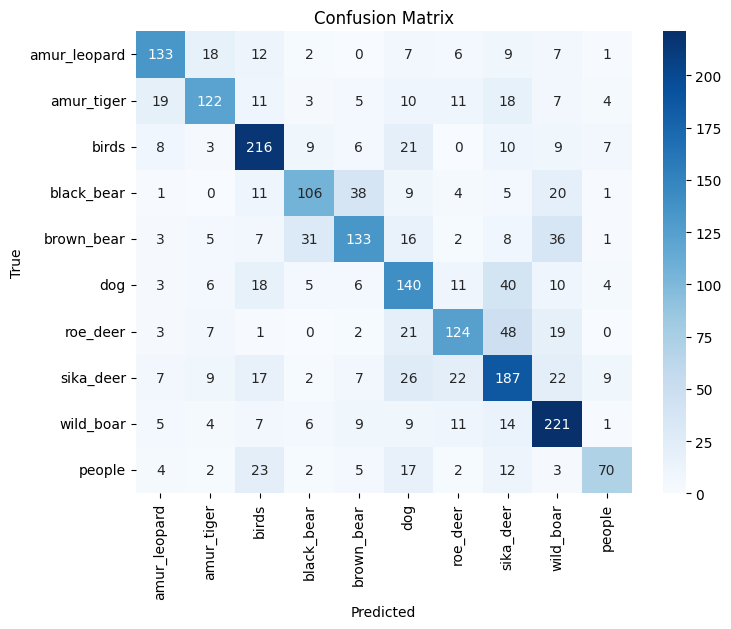

<Figure size 640x480 with 0 Axes>

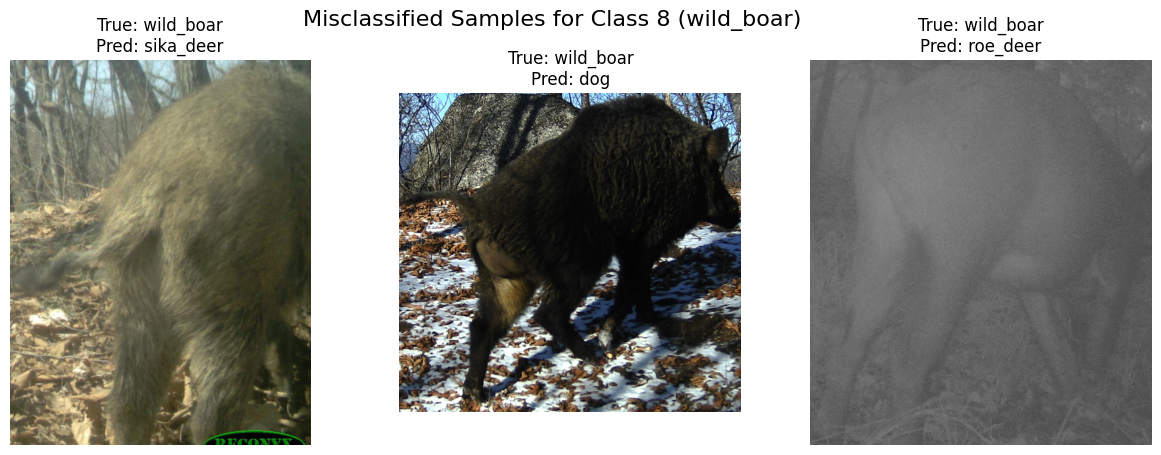

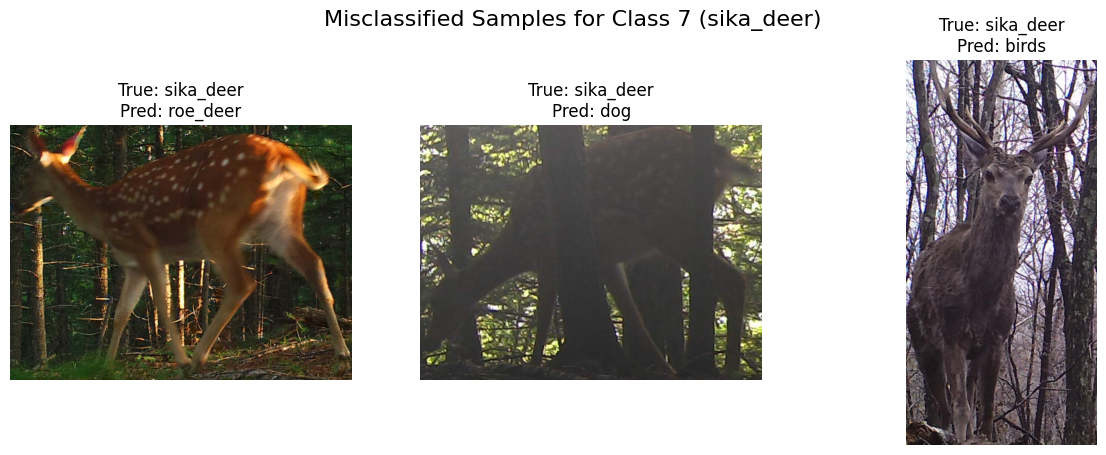

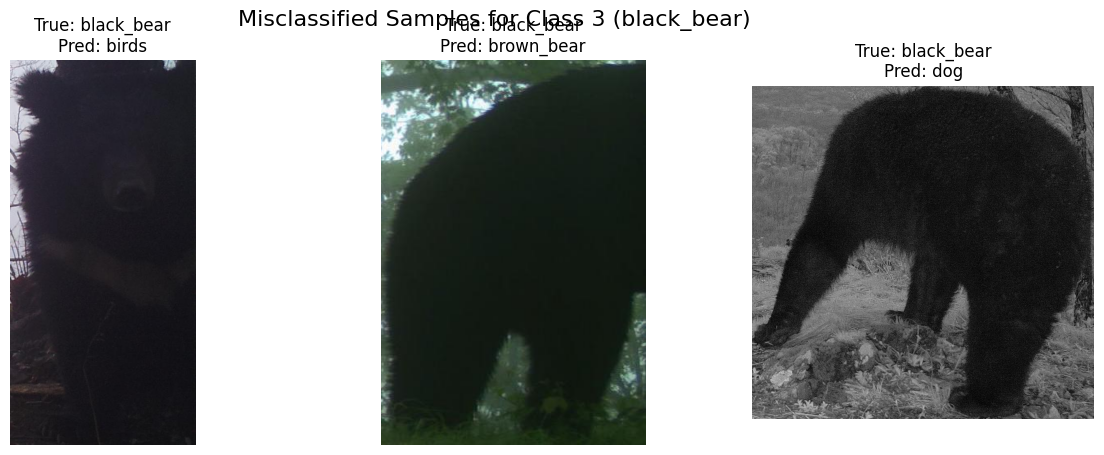

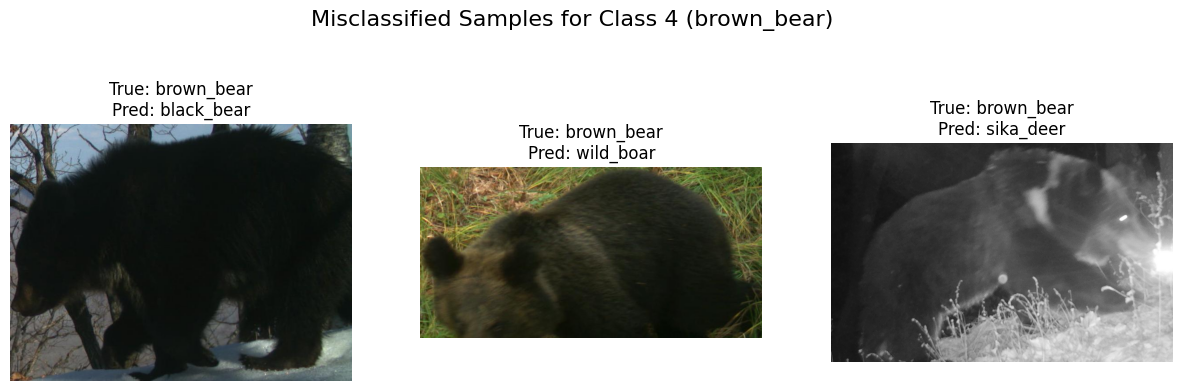

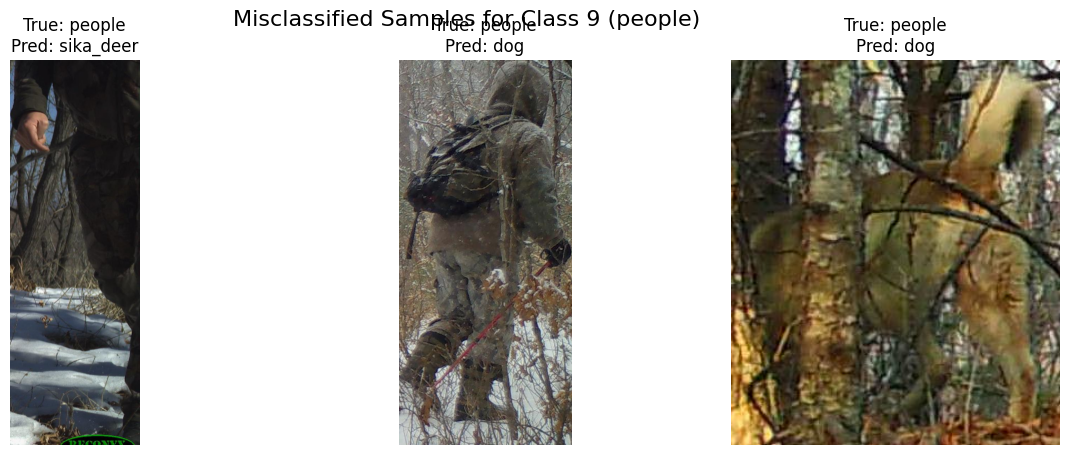

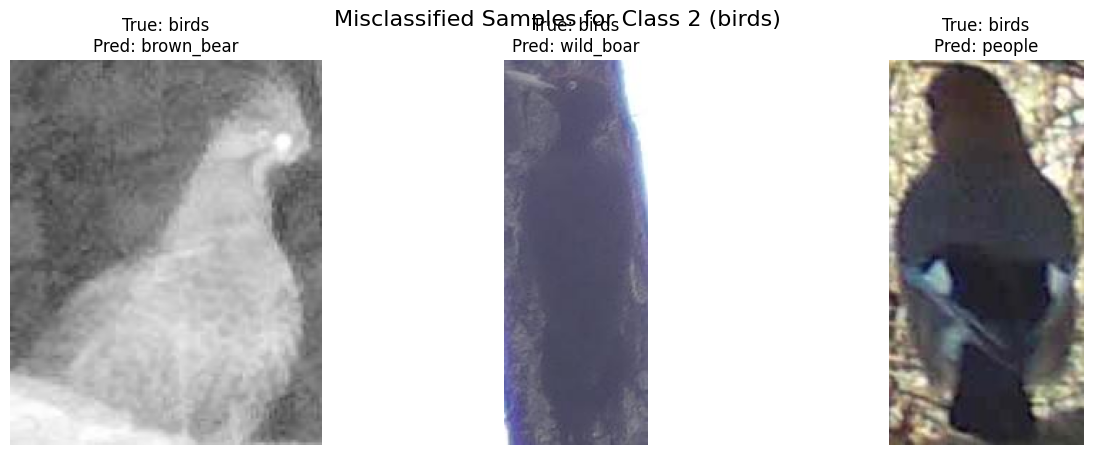

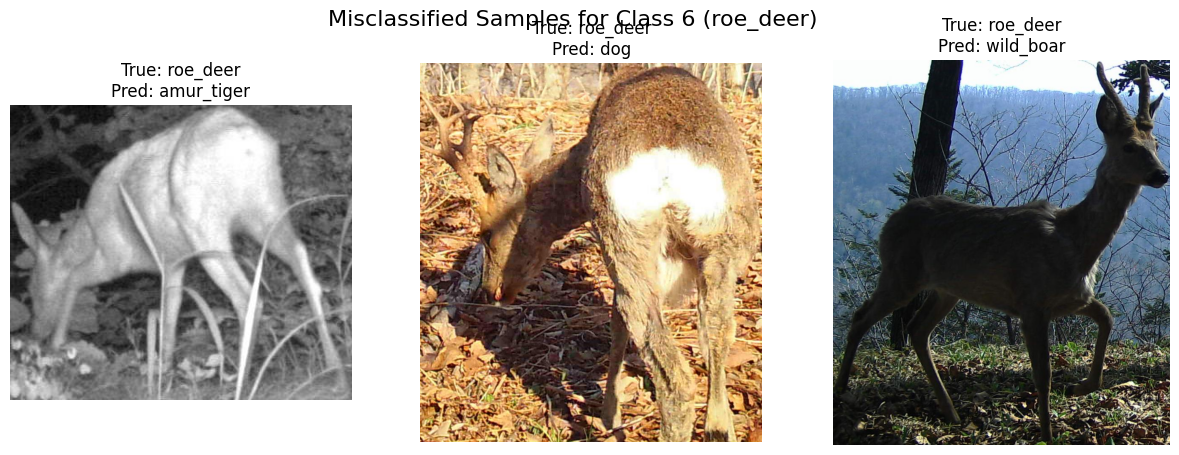

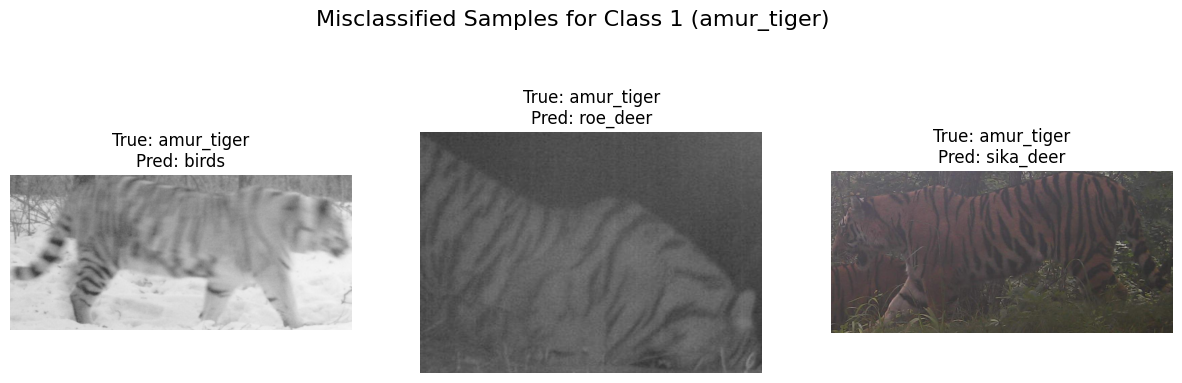

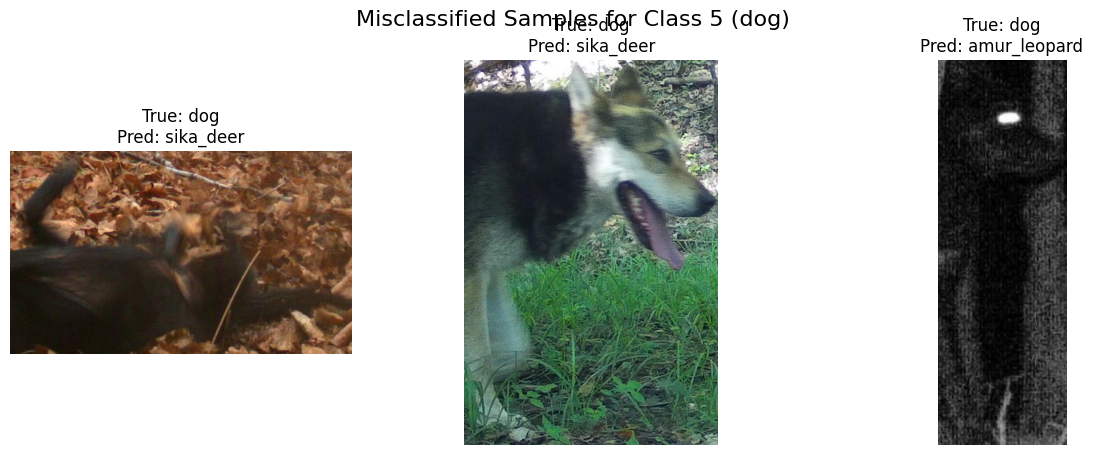

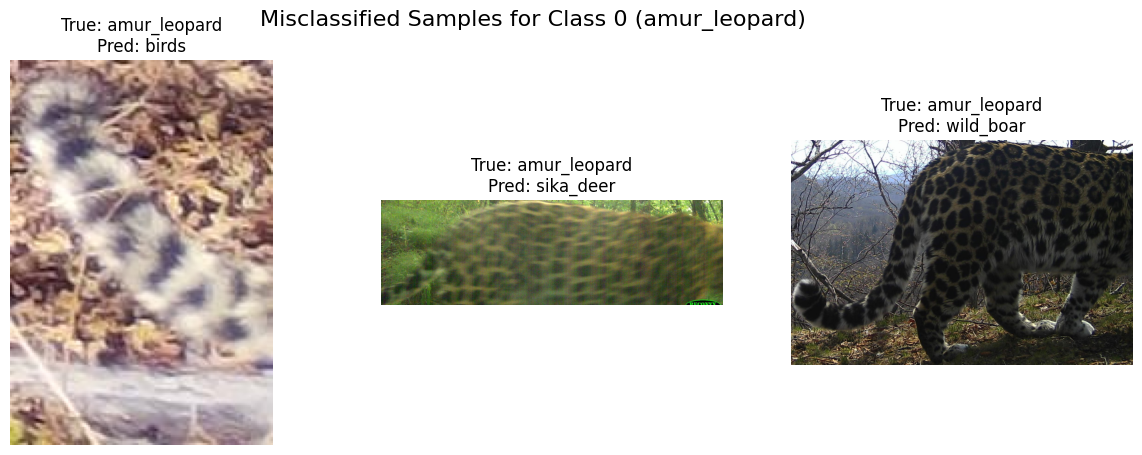

In [ ]:
import os
import torch
import wandb
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image

# # ✅ (1a) Initialize Weights & Biases (WandB)
wandb.init(project="russian-wildlife-cnn")



# ✅ (2a) Define CNN Model with 3 Conv Layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32 Filters
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)  # MaxPool (4x4, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 64 Filters
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool (2x2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 128 Filters
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool (2x2, stride=2)
        self.fc = nn.Linear(128 * 14 * 14, 10)  # Fully Connected Layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ✅ (2b) Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ✅ (2b) Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc})

wandb.finish()

# ✅ (2d) Validation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ (2d) Compute Metrics
val_acc = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# ✅ (2d) Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ✅ (2d) Log Confusion Matrix to WandB
wandb.init(project="russian-wildlife-cnn")
wandb.log({"confusion_matrix": wandb.Image(plt)})
wandb.finish()

# ------------------------- Part 2(e): Misclassified Images Visualization -------------------------
# For each class in the validation set, visualize any 3 misclassified images along with predicted labels.

# We assume that the validation DataLoader is in the same order as val_paths and val_labels.
# 'all_preds' and 'all_labels' are lists of predictions and ground-truth labels (in order).

# Identify misclassified sample indices
misclassified_indices = [i for i in range(len(val_labels)) if all_preds[i] != val_labels[i]]

# Group misclassified samples by their true label
misclassified_by_class = {}
for idx in misclassified_indices:
    true_label = val_labels[idx]
    pred_label = all_preds[idx]
    if true_label not in misclassified_by_class:
        misclassified_by_class[true_label] = []
    misclassified_by_class[true_label].append((idx, pred_label))

# Visualize up to 3 misclassified images per class
for true_label, samples in misclassified_by_class.items():
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Misclassified Samples for Class {true_label} ({list(class_mapping.keys())[true_label]})", fontsize=16)
    for i, (idx, pred_label) in enumerate(samples[:3]):
        img_path = val_paths[idx]
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {list(class_mapping.keys())[true_label]}\nPred: {list(class_mapping.keys())[pred_label]}")
        plt.axis("off")
    plt.show()

# Analysis (to be added in your report):
# - Consider whether misclassifications occur because the image lacks clear features of the ground-truth class,
#   or if the image resembles the predicted class.
# - Potential workarounds include additional data augmentation, collecting more diverse training samples,
#   or using more robust models/feature extraction methods.

# ------------------------- End of Code -------------------------

part 3

Loading Data...
Total Images: 11668


C:\Users\aksha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aksha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Accuracy: 85.69%
F1 Score: 0.8576


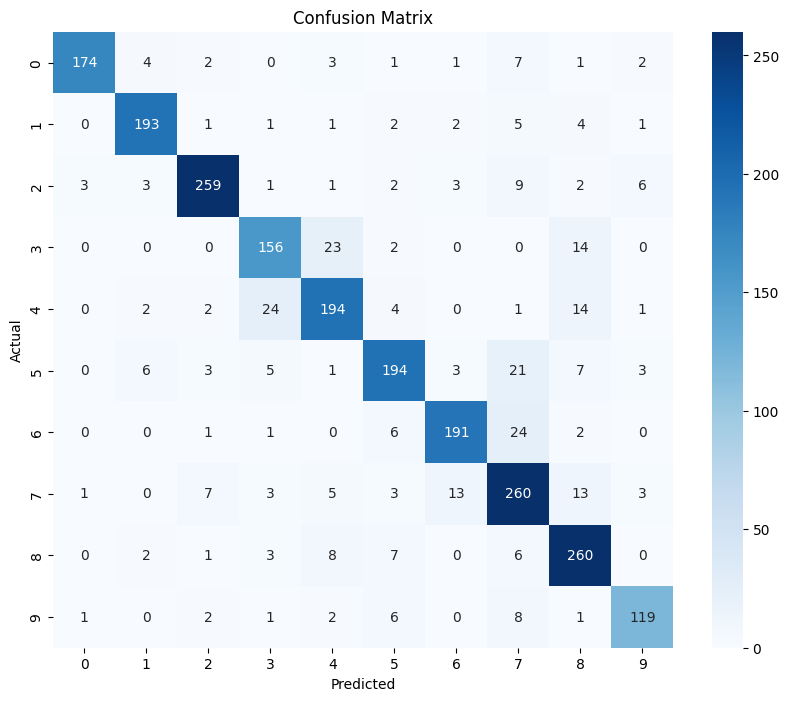

<Figure size 640x480 with 0 Axes>

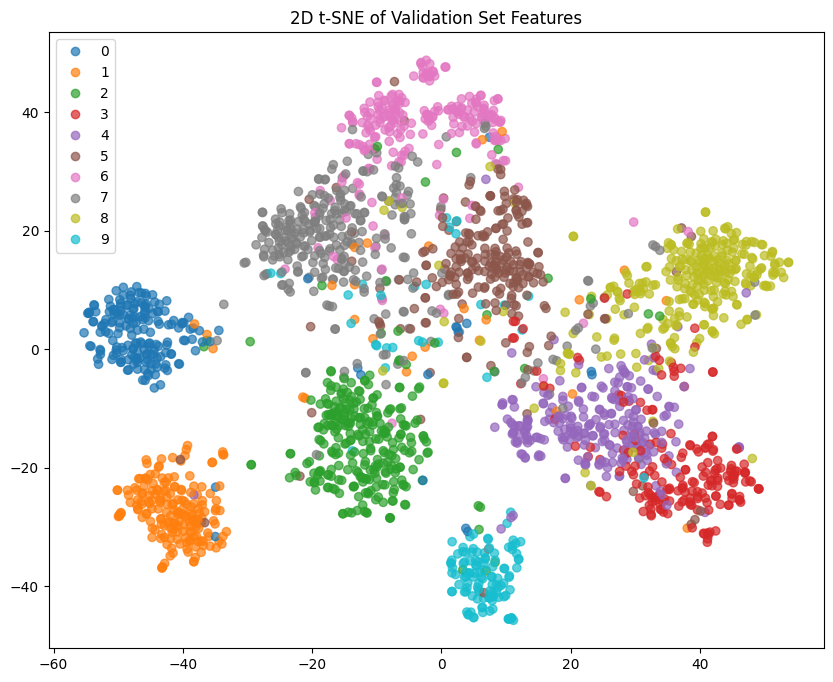

<Figure size 640x480 with 0 Axes>

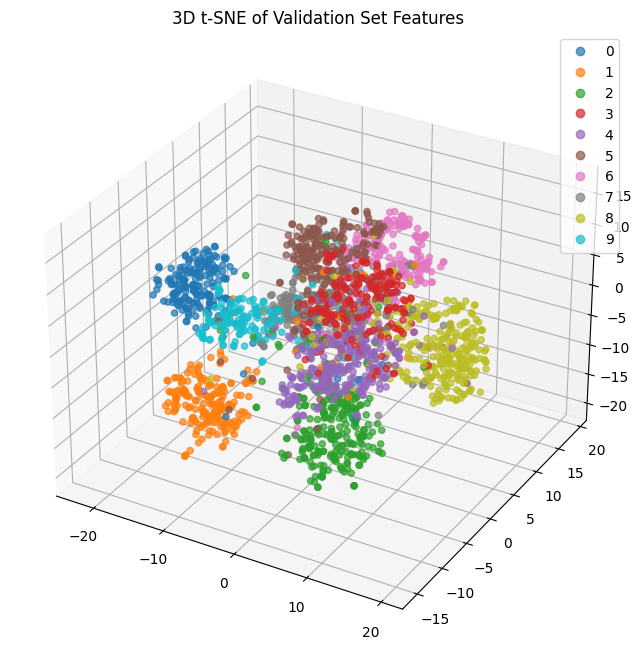

<Figure size 640x480 with 0 Axes>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import numpy as np
from PIL import Image

# Initialize Weights & Biases (wandb) for logging
wandb.init(project="resnet18_finetune")

# Create list of image paths and labels
image_paths = []
labels = []
print("Loading Data...")
for class_name, class_label in class_mapping.items():
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            if img_file.endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(class_folder, img_file))
                labels.append(class_label)

# Convert to numpy arrays for stratified split
image_paths = np.array(image_paths)
labels = np.array(labels)
print(f"Total Images: {len(image_paths)}")

# ✅ (1a) Custom Dataset Class
class WildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")  # Open Image
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.int64)  # ✅ Ensure labels are long



# (a) Fine-tuning ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        # Load pre-trained ResNet-18 model
        self.model = models.resnet18(pretrained=True)
        # Replace the final fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming train_image_paths, train_labels, val_image_paths, and val_labels are defined
train_dataset = WildlifeDataset(image_paths=train_paths, labels=train_labels, transform=transform)
val_dataset = WildlifeDataset(image_paths=val_paths, labels=val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = ResNet18(num_classes=10)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training and validation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Log to wandb
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Validation Loss": val_loss,
        "Validation Accuracy": val_accuracy
    })

# (b) Analyze training and validation loss to check for overfitting
# This part involves visual inspection of the loss plots in wandb dashboard.

# (c) Report Accuracy and F1-Score on the validation set
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"F1 Score: {f1:.4f}")

# Log metrics to wandb
wandb.log({
    "Validation Accuracy": val_accuracy,
    "F1 Score": f1
})

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
wandb.log({"Confusion Matrix": wandb.Image(plt)})

# (d) t-SNE Visualization
# Extract feature vectors using the model's backbone
model.eval()
feature_extractor = nn.Sequential(*list(model.model.children())[:-1])  # Remove final FC layer

features, labels_list = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        output = feature_extractor(images)
        features.append(output.view(output.size(0), -1).cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features = np.concatenate(features)
labels_list = np.array(labels_list)

# 2D t-SNE Plot
tsne_2d = TSNE(n_components=2, random_state=42)
features_2d = tsne_2d.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.title('2D t-SNE of Validation Set Features')
plt.show()
wandb.log({"2D t-SNE": wandb.Image(plt)})

# 3D t-SNE Plot
tsne_3d = TSNE(n_components=3, random_state=42)
features_3d = tsne_3d.fit_transform(features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=labels_list, cmap='tab10', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
ax.set_title('3D t-SNE of Validation Set Features')
plt.show()
wandb.log({"3D t-SNE": wandb.Image(plt)})
 


part 4

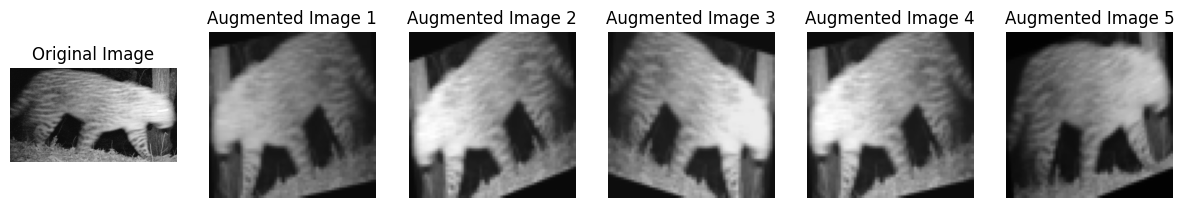

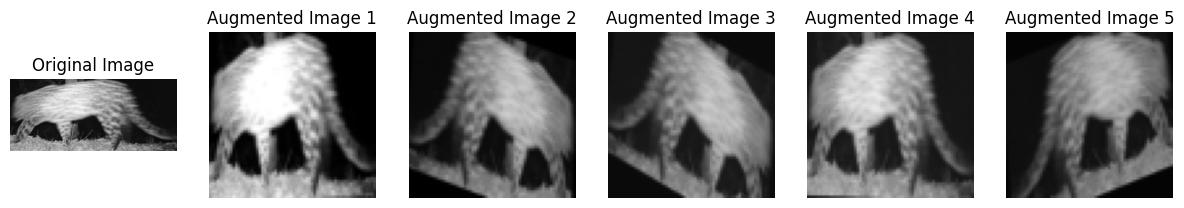

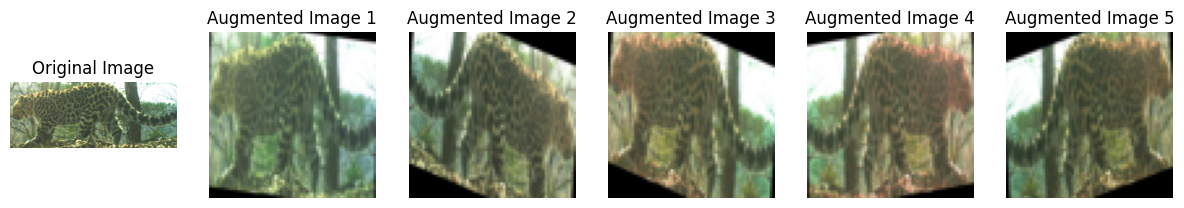

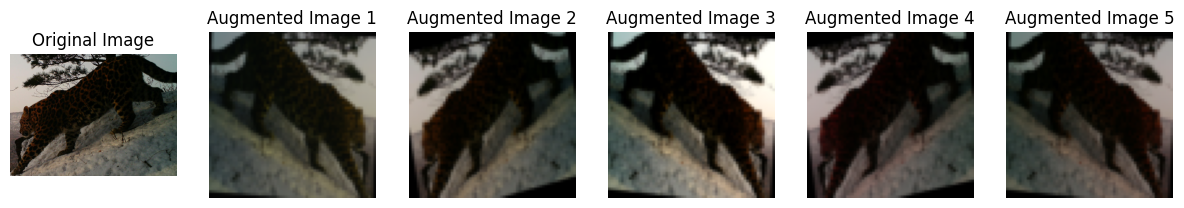

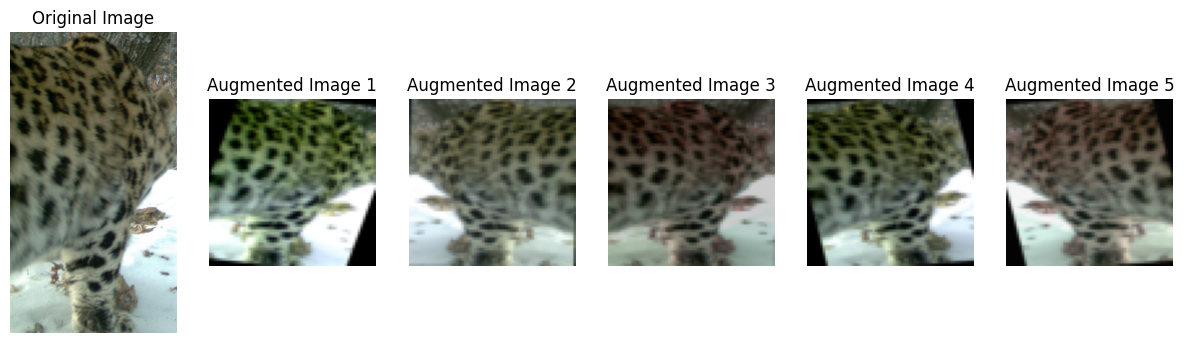

C:\Users\aksha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aksha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Accuracy: 87.66%
F1-Score: 0.88


In [4]:
#a
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt



# Define the augmentation pipeline
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to visualize augmented images
def visualize_augmentations(image_path, transform, num_samples=5):
    original_image = Image.open(image_path).convert("RGB")
    fig, axes = plt.subplots(1, num_samples + 1, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    for i in range(num_samples):
        augmented_image = transform(original_image)
        augmented_image = augmented_image.permute(1, 2, 0)  # CHW to HWC
        augmented_image = augmented_image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        augmented_image = augmented_image.clamp(0, 1)  # Clamp to valid range
        axes[i + 1].imshow(augmented_image)
        axes[i + 1].set_title(f"Augmented Image {i + 1}")
        axes[i + 1].axis('off')
    
    plt.show()

# Example usage 1
image_path = "russian-wildlife-dataset-20250204T231459Z-001/russian-wildlife-dataset/Cropped_final/amur_leopard/0053_al_n_crop00_detections.jpg"  # Replace with your image path
visualize_augmentations(image_path, augmentation_transforms)

# Example usage 2
image_path = 'russian-wildlife-dataset-20250204T231459Z-001/russian-wildlife-dataset/Cropped_final/amur_leopard/0054_al_n_crop00_detections.jpg'  # Replace with your image path
visualize_augmentations(image_path, augmentation_transforms)

# Example usage 3
image_path = 'russian-wildlife-dataset-20250204T231459Z-001/russian-wildlife-dataset/Cropped_final/amur_leopard/0055_al_d_s_crop00_detections.jpg'  # Replace with your image path
visualize_augmentations(image_path, augmentation_transforms)

# Example usage 4
image_path = 'russian-wildlife-dataset-20250204T231459Z-001/russian-wildlife-dataset/Cropped_final/amur_leopard/0057_al_d_w_crop00_detections.jpg'  # Replace with your image path
visualize_augmentations(image_path, augmentation_transforms)

# Example usage 5
image_path = 'russian-wildlife-dataset-20250204T231459Z-001/russian-wildlife-dataset/Cropped_final/amur_leopard/0059_al_d_w_crop00_detections.jpg'  # Replace with your image path
visualize_augmentations(image_path, augmentation_transforms)


#b
from torch.utils.data import DataLoader

# Assuming WildlifeDataset is defined as in previous code
train_dataset = WildlifeDataset(image_paths=train_paths, labels=train_labels, transform=augmentation_transforms)
val_dataset = WildlifeDataset(image_paths=val_paths, labels=val_labels, transform=transform)  # No augmentation for validation

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, loss function, and optimizer setup (as previously defined)
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.int64)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.int64)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Log to wandb
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Validation Loss": val_loss,
        "Validation Accuracy": val_accuracy
    })


#c
#After training, examine the training and validation loss plots logged in wandb. If the training loss decreases while the validation loss remains stable or decreases, it suggests that data augmentation has helped mitigate overfitting. Conversely, if the validation loss increases as the training loss decreases, overfitting may still be an issue.


#d
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Compute metrics
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"F1-Score: {f1:.2f}")
 
